In [0]:
import sympy as sym
sym.init_printing(use_latex='matplotlib')

import numpy as np
from scipy.integrate import odeint
import torch
from torch.autograd import Function
import torch.nn as nn
import pyro
from pyro.nn import PyroSample
from pyro.nn import PyroModule
import pyro.distributions as dist
from pyro.infer.autoguide import AutoMultivariateNormal

from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import AdagradRMSProp
import matplotlib.pyplot as plt
%matplotlib inline

# SIR compartmental model

In this notebook we are going to demonstrate variational inference (and NUTS) using the famous SIR model. The [SIR model](https://doi.org/10.1098/rspa.1927.0118) of infectious disease models the number of susceptible ($S$), infected ($I$), and recovered ($R$) people in a population subjected to an epidemic. Such models are also known as compartmental models due to its nature of dividing the population into compartments according to the disease progression. 
The SIR model, for a population of $N$ people, is defined by the following ODE system: 
\begin{aligned}
\frac{d S}{d t} &= -\beta S \frac{I}{N}\\
\frac{d I}{d t} &= \beta S \frac{I}{N} - \gamma I\\
\frac{d R}{d t} &= \gamma I,\\
\end{aligned}
where the parameters are $\beta$ (infection rate), and $\gamma$ (recovery rate). The basic reproduction ratio $R_0$ is given by $\beta/\gamma$. Moreover, we have $N = S(t) + I(t) + R(t)$.

To illustrate the inverse problem, i.e. model fitting, we would use data on [Common colds on Tristan da Cunha](https://doi.org/10.1017/S0022172400021677), used to fit this model for demonstrating the [ABC-SMC method (data taken from this paper)](https://doi.org/10.1098/rsif.2008.0172). This data consists of the number of infections $I(t)$ and number of recoveries $R(t)$ for a period of $21$ days. The population $N=300$.

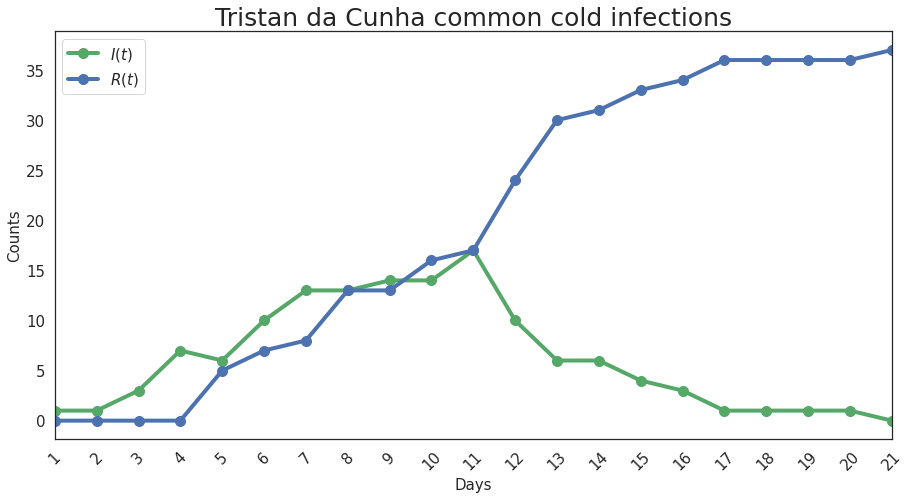

In [0]:
times = np.arange(0,21, 1)
N_pop = 300
data =np.array([
            [1, 0],     # day 1
            [1, 0],
            [3, 0],
            [7, 0],
            [6, 5],     # day 5
            [10, 7],
            [13, 8],
            [13, 13],
            [14, 13],
            [14, 16],    # day 10
            [17, 17],
            [10, 24],
            [6, 30],
            [6, 31],
            [4, 33],    # day 15
            [3, 34],
            [1, 36],
            [1, 36],
            [1, 36],
            [1, 36],    # day 20
            [0, 37],    # day 21
        ])
I, R = data[:,0], data[:,1]
Y = I
plt.figure(figsize=(15, 7.5))
plt.plot(times+1,I,'o-', ms=10,color='g', lw=4, label=r"$I(t)$")
plt.plot(times+1,R,'o-', ms=10,color='b', lw=4, label=r"$R(t)$")
plt.legend(fontsize=15)
plt.xlim([1,21])
plt.xlabel('Days', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.xticks(times+1,rotation=45)
plt.title('Tristan da Cunha common cold infections', fontsize=25);

# Parameter estimation

We will be fitting the SIR model shown above to this data. Of course this is a very simple model, but it is good enough for our purpose of demonstrating our methods with count data. Note that for fitting we will be using only the number of infections $I(t)$ series. 

In addition to the two parameters $\beta$ and $\gamma$ we also need to estimate the initial susceptibility, $s_0 = S(t=0)/N$. Note that we assume the initial recovered fraction to be $r_0=0$ and $i_0 = 1 - s_0$.

# Define the model using sympy Jacobians

We will be using ``Lamdify`` for the Jacobians. The following code-block are written similarly to the other examples. Thus, one can skip these sections and go to the ``pyro`` model (probabilistic) sections.

In [0]:
class OdeSolverForwardSens(object):
    def __init__(self):
        super(OdeSolverForwardSens, self).__init__()

    def _rhs(self, y, t, p):
        raise NotImplementedError
    
    def _jac_y(self, y):
        raise NotImplementedError
    
    def _jac_p(self, y):
        raise NotImplementedError
    
    def set_unknown_y0(self, n_ivs, dy0dy0, custom=True):
        self._unknown_y0 = True
        self._custom_y0 = custom
        self._n_ivs = n_ivs
        self._dy0dy0 = dy0dy0

    def set_custom_y0(self, y0):
      raise NotImplementedError
    
    def solve(self, parameters):
        return self._solve(parameters, False)

    def solve_with_sensitivities(self, parameters):
        return self._solve(parameters, True)

    def _solve(self, parameters, sensitivities):

        if sensitivities:
            self._params = parameters           
            
            def augmented_ode(y_and_dydp, t, p):
                
                y = y_and_dydp[0:self._n_states]
                dydp = y_and_dydp[self._n_states:].reshape((
                    self._n_states, self._n_params))
                dydt = self._rhs(y, t, p)
                d_dydp_dt = np.matmul(self._jac_x(y, p), dydp) + self._jac_p(y, p)
                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))    
            
            y0 = np.zeros(self._n_states + (self._n_states * self._n_params))
            
            if self._unknown_y0:
              if self._custom_y0:
                y0 = self.set_custom_y0(y0, parameters)
              else:
                y0[self._dy0dy0[self._n_ivs:]] = 1.
                y0[self._dy0dy0[:self._n_ivs]] = parameters[-self._n_ivs:]

            else:
                y0[0:self._n_states] = self._y0
            
            result = odeint(augmented_ode, y0, self._times, (parameters,), 
                            rtol=self._rtol, atol=self._atol)
            x = result[:, 0:self._n_states]
            dx_dp = result[:, self._n_states:].reshape((
                len(times), self._n_states, self._n_params))
            return x, dx_dp
        else:
            return odeint(self._rhs, self._y0, self._times, (parameters,),
                            rtol=self._rtol, atol=self._atol)

## The ODE velocity field

In [0]:
def r(y, t, p):
    
    S, I, R=y
    beta, gamma, S0 = p
    dS_dt = - (beta * I * S)
    dI_dt = (beta * I * S) - (gamma * I)
    dR_dt = gamma * I
    return dS_dt,dI_dt,dR_dt


## Now use `SymPy` for all expressions of Jacobians

In [0]:
y, p = sym.symbols('y:3'), sym.symbols('p:3')
ydot = r(y, None, p)
ydot

In [0]:
t = sym.symbols('t')  
rhs_f = sym.lambdify((y, t, p), ydot)  

In [0]:
jac_x = sym.Matrix(ydot).jacobian(y)
jac_x

⎡-p₀⋅y₁    -p₀⋅y₀    0⎤
⎢                     ⎥
⎢p₀⋅y₁   p₀⋅y₀ - p₁  0⎥
⎢                     ⎥
⎣  0         p₁      0⎦

In [0]:
jac_p = sym.Matrix(ydot).jacobian(p)
jac_p

⎡-y₀⋅y₁   0   0⎤
⎢              ⎥
⎢y₀⋅y₁   -y₁  0⎥
⎢              ⎥
⎣  0     y₁   0⎦

In [0]:
jac_x_f = sym.lambdify((y, p), jac_x)
jac_p_f = sym.lambdify((y, p), jac_p)

## Extend the class above and pass in the `Lambdas`

We have added one little method ``set_custom_y0`` to handle the case of $i_0 = 1 - s_0$. Note that the gotcha here is that the initial value for sensitivity of $I(t)$ w.r.t $s_0$, $\frac{d I}{d s_0}$ will be $-1$. 

In [0]:
class SIRModel(OdeSolverForwardSens):
    
    def __init__(self, _rhs_f, _jac_x_f, _jac_p_f, n_states, n_params, times,
                 rtol=1e-5, atol=1e-6, y0=None):
        super(SIRModel, self).__init__()
               
        if y0 is None:
            self._y0 = np.array(np.zeros(n_states), dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float) 
        self._rhs_f = _rhs_f
        self._jac_x_f = _jac_x_f
        self._jac_p_f = _jac_p_f
        
        self._n_states = n_states
        self._n_params = n_params
        self._times = times
        self._T = len(times)
        self._rtol = rtol
        self._atol = atol  

        
    def _rhs(self, y, t, p):
        return self._rhs_f(y, t, p)

    def _jac_x(self, y, p):
        return self._jac_x_f(y, p)

    def _jac_p(self, y, p):
        return self._jac_p_f(y, p)

    def set_custom_y0(self, y0, p):
      temp = y0.copy()
      temp[self._dy0dy0[2]] = 1.
      temp[self._dy0dy0[3]] = -1.
      temp[self._dy0dy0[0]] = p[-1]
      temp[self._dy0dy0[1]] = 1 - p[-1]
      return temp

### Mark intial values for estimation and sensitivity

Note that although we have just one unknown initial value as a parameter we set up the system as having two unknown intial values. This is to handle the relation $s_0 = 1 - i_0$. Of course this is just our way of coding up quickly and there must be better way of handling this.

In [0]:
sir_ode_model = SIRModel(rhs_f, jac_x_f, jac_p_f, 3, 3, times, 1e-5, 1e-5, [0.9,0.1,0.0]);
sir_ode_model.set_unknown_y0(2, [0,1,5,8], True)

## Custom ODE op

This is written exactly the same as the ``autoJac`` ntebooks have introduced.

In [0]:
class ODEop(Function):  
    @staticmethod
    def forward(ctx, params, model): 
        numpy_params = params.detach().numpy() 
        sol, Jac = model.solve_with_sensitivities(numpy_params)
        ctx.T, ctx.k, ctx.d = model._T, model._n_states, model._n_params
        ctx.save_for_backward(torch.as_tensor(Jac, dtype=params.dtype))
        return torch.as_tensor(sol[:,1], dtype=params.dtype)

    @staticmethod
    def backward(ctx, grad_output):
        T = ctx.T
        d = ctx.d
        k = ctx.k
        bJac = ctx.saved_tensors[0]
        
        numpy_Jac = bJac.detach().numpy()
        v = grad_output.detach().numpy()
        #print(v)
        vjp = numpy_Jac[:,1,:].T.dot(v)
        return grad_output.new(torch.as_tensor(vjp)), None #<----Since the second input is the ode_model object

## Define the Generative model

The basic modelling assumption is that the data, $Y(t)$, is distributed as Poisson whose intensity is modulated by the ODE:
\begin{aligned}
Y(t) &\sim \operatorname{Poisson}(\lambda_t)\\
\lambda_t &= \int_{s=0}^t \bigg(\beta S(s)\frac{I(s)}{N} - \gamma I(s)\bigg) ds,
\end{aligned}

and we place the following priors:
\begin{aligned}
\beta &\sim \operatorname{Gamma}(2,1)\\
\gamma &\sim \operatorname{Gamma}(2,1)\\
s_0 &\sim \operatorname{Beta}(0.5,0.5)
\end{aligned}

In [0]:
from pyro.nn import PyroSample
from pyro.nn import PyroModule

class SIRGenModel(PyroModule):
    def __init__(self, ode_model, N_pop):        
        super(SIRGenModel, self).__init__()
        self._ode_model = ode_model
        self._N_pop = N_pop
        self.ode_params1 = PyroSample(dist.Gamma(2,1))
        self.ode_params2 = PyroSample(dist.Gamma(2,1)) 
        self.ode_params3 = PyroSample(dist.Beta(0.5,0.5))
        
    def forward(self, data): 
        
        #scale = pyro.sample("scale", dist.HalfCauchy(scale=2))
        I_sim = ODEop.apply(torch.stack([self.ode_params1,self.ode_params2,self.ode_params3]), self._ode_model)
        #print(I_sim[:,1:10].numpy())
        for i in range(len(data)):
          pyro.sample("obs_{}".format(i), dist.Poisson(I_sim[i]*self._N_pop), obs=data[i])
        return I_sim
        


## Define the variational approximation

In [0]:
y_torch = torch.tensor(Y,dtype=torch.float)
model = SIRGenModel(sir_ode_model,N_pop=300)
guide = AutoMultivariateNormal(model,init_scale=.1)
pyro.set_rng_seed(122)
pyro.clear_param_store()
optim = AdagradRMSProp({"eta": 0.5})
svi = SVI(model, guide, optim, loss=Trace_ELBO(num_particles=1))

## Maximise the ELBO

In [0]:
def train():
    loss_trace = []
    for j in range(10000):
        loss = svi.step(y_torch)
        loss_trace.append(loss)

        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, np.mean(loss_trace[-100:])))
    return loss_trace

In [0]:
%%time
loss_graph = train()
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

/content/pyro/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


[iteration 0001] loss: nan
[iteration 0501] loss: 49.2891
[iteration 1001] loss: 48.5062
[iteration 1501] loss: 48.0394
[iteration 2001] loss: 47.8330
[iteration 2501] loss: 47.6176
[iteration 3001] loss: 47.5172
[iteration 3501] loss: 47.5983
[iteration 4001] loss: 47.5821
[iteration 4501] loss: 47.5338
[iteration 5001] loss: 47.4960
[iteration 5501] loss: 47.5801
[iteration 6001] loss: 47.4253
[iteration 6501] loss: 47.5799
[iteration 7001] loss: 47.3161
[iteration 7501] loss: 47.4280
[iteration 8001] loss: 47.4318
[iteration 8501] loss: 47.3314
[iteration 9001] loss: 47.3777
[iteration 9501] loss: 47.3627
AutoMultivariateNormal.loc Parameter containing:
tensor([0.5431, 0.1945, 5.5670], requires_grad=True)
AutoMultivariateNormal.scale_tril tensor([[ 0.0691,  0.0000,  0.0000],
        [ 0.0741,  0.0281,  0.0000],
        [ 0.2978, -0.0903,  0.1581]], grad_fn=<AddBackward0>)
CPU times: user 3min 42s, sys: 1.18 s, total: 3min 43s
Wall time: 3min 43s


In [0]:
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("ode_params1","ode_params2","ode_params3","obs", "_RETURN"))#"ode_params", "scale", 
vb_ppc_samples = predictive(y_torch)

In [0]:
vb_params=np.concatenate((vb_ppc_samples['ode_params1'][:,None].detach().numpy(),
                          vb_ppc_samples['ode_params2'][:,None].detach().numpy(),
                          vb_ppc_samples['ode_params3'][:,None].detach().numpy()
                          ),axis=1)

# Now lets run MCMC for comparison

In [0]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(y_torch)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Warmup:   0%|          | 0/2000 [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Sample: 100%|██████████| 2000/2000 [10:13,  3.26it/s, step size=1.92e-01, acc. prob=0.943]


In [0]:
mc_params=np.concatenate((hmc_samples['ode_params1'][:,None],
                          hmc_samples['ode_params2'][:,None],
                          hmc_samples['ode_params3'][:,None]
                          ),axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


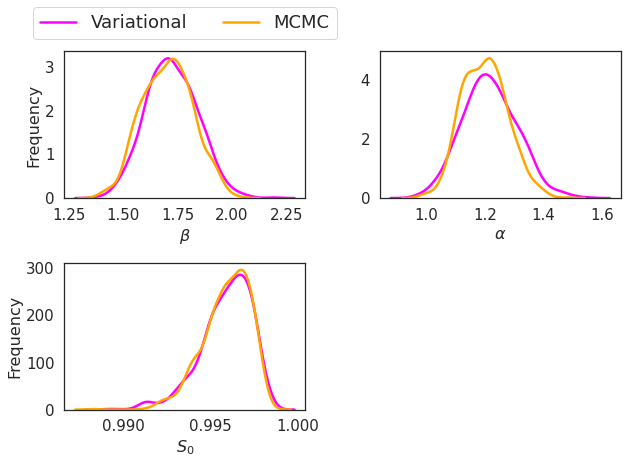

In [0]:
import seaborn as sns
sns.set_context("paper", font_scale=1)
sns.set(rc={"figure.figsize":(9,9),"font.size":16,"axes.titlesize":16,"axes.labelsize":16,
           "xtick.labelsize":15, "ytick.labelsize":15},style="white")
param_names = [r"$\beta$",r"$\alpha$", r"$S_0$"]

for i, p in enumerate(param_names):
        
        plt.subplot(3, 2, i+1)
        #plt.axvline(real_params[i], linewidth=2.5, color='black')
        if i==0:
            sns.kdeplot(vb_params[:, i], color='magenta', linewidth = 2.5, label='Variational')
            sns.kdeplot(mc_params[:, i], color='orange', linewidth = 2.5, label='MCMC')
        else:
            sns.kdeplot(vb_params[:, i], linewidth = 2.5, color='magenta')
            sns.kdeplot(mc_params[:, i], linewidth = 2.5, color='orange')
            
        if i%2==0:
            plt.ylabel('Frequency')
        plt.xlabel(param_names[i])        
        if i<1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()

## MCMC takes more than twice the time for having similar estimate!

## Lets see how the model fits the data, using the Variational approximation

We will be using ppc samples of predicted epidemic curves by drawing from the posterior predictive, using variational approximation.



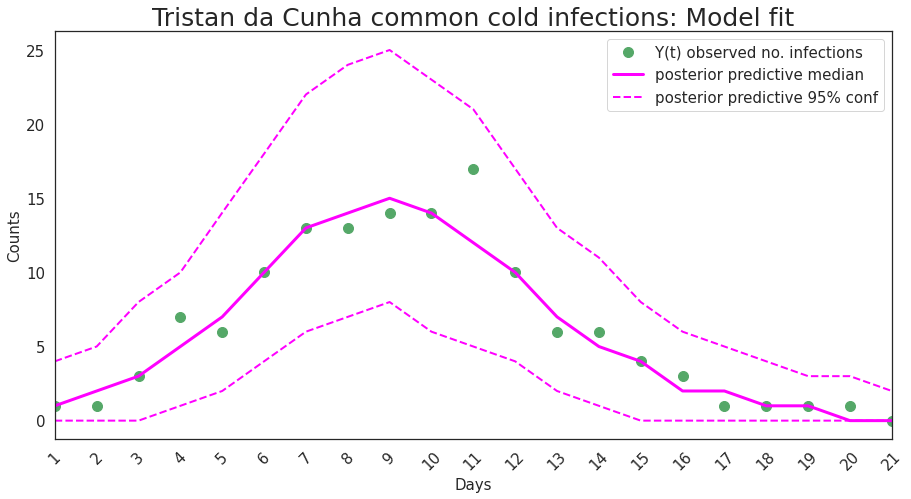

In [0]:
epi_curve_vb=vb_ppc_samples["_RETURN"].detach().numpy()*N_pop
center_epi_curve_vb=np.percentile(np.random.poisson(epi_curve_vb),50,axis=0)
lb_epi_curve_vb=np.percentile(np.random.poisson(epi_curve_vb),2.5,axis=0)
ub_epi_curve_vb=np.percentile(np.random.poisson(epi_curve_vb),97.5,axis=0)
plt.figure(figsize=(15, 7.5))
plt.plot(times+1,I,'o',color='g',ms=10, lw=4, label="Y(t) observed no. infections")
plt.plot(times+1,center_epi_curve_vb,color='magenta', lw=3, label="posterior predictive median")
plt.plot(times+1,lb_epi_curve_vb,'--',color='magenta', lw=2, label="posterior predictive 95% conf")
plt.plot(times+1,ub_epi_curve_vb,'--',color='magenta', lw=2)
plt.legend(fontsize=15)
plt.xlim([1,21])
plt.xlabel('Days', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.xticks(times+1,rotation=45)
plt.title('Tristan da Cunha common cold infections: Model fit', fontsize=25);

## Finally, lets check our estimate of $R_0$


Text(0.5, 0, '$R_0$')

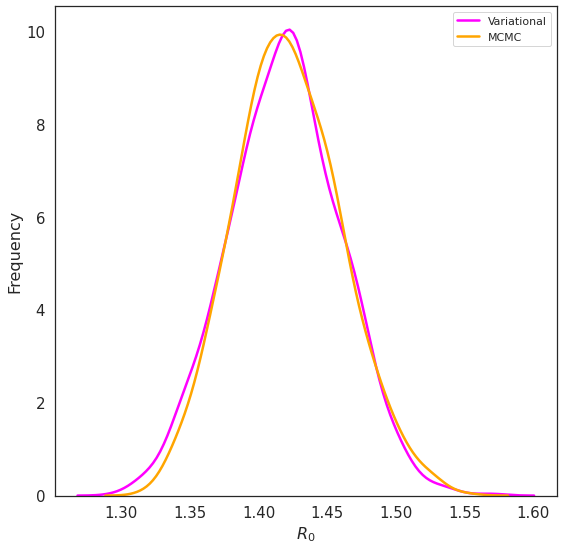

In [0]:
sns.kdeplot(vb_params[:,0]/vb_params[:,1], color='magenta', linewidth = 2.5, label='Variational')
sns.kdeplot(mc_params[:,0]/mc_params[:,1], color='orange', linewidth = 2.5, label='MCMC')
plt.ylabel('Frequency')
plt.xlabel(r"$R_0$")